<a href="https://colab.research.google.com/github/daniel-idowu-01/3d-portfolio/blob/main/Email_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import LabelEncoder

# required models
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

import pickle

from collections import Counter

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
df = pd.read_csv("email.csv")
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df.shape

(5573, 2)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5573 entries, 0 to 5572
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5573 non-null   object
 1   Message   5573 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [ ]:
df.isnull().sum()

,0
Category,0
Message,0


In [ ]:
df.duplicated().sum()

np.int64(415)

In [ ]:
df['no_char'] = df['Message'].apply(len)
df['no_words'] = df['Message'].apply(lambda x: len(x.split()))
df['no_sent'] = df['Message'].apply(lambda x: len(x.split('.')))
df.head()

,Category,Message,no_char,no_words,no_sent
0,ham,"Go until jurong point, crazy.. Available only ...",111,20,9
1,ham,Ok lar... Joking wif u oni...,29,6,7
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28,2
3,ham,U dun say so early hor... U c already then say...,49,11,7
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,13,1


In [ ]:
df['Category'] = df['Category'].str.strip().str.lower()
df = df[df['Category'].isin(['ham', 'spam'])]

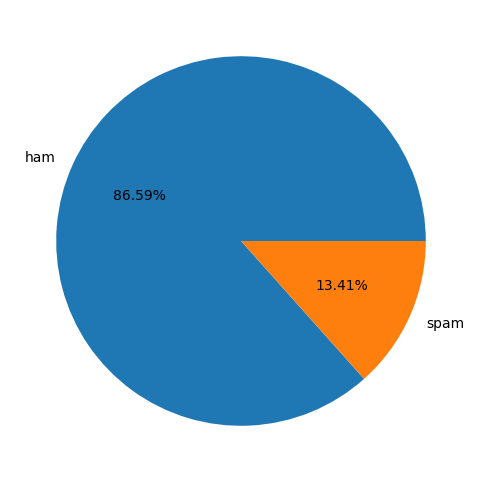

In [ ]:
plt.figure(figsize=(12, 6))
plt.pie(df['Category'].value_counts(), labels=['ham', 'spam'], autopct='%0.2f%%')
plt.show()

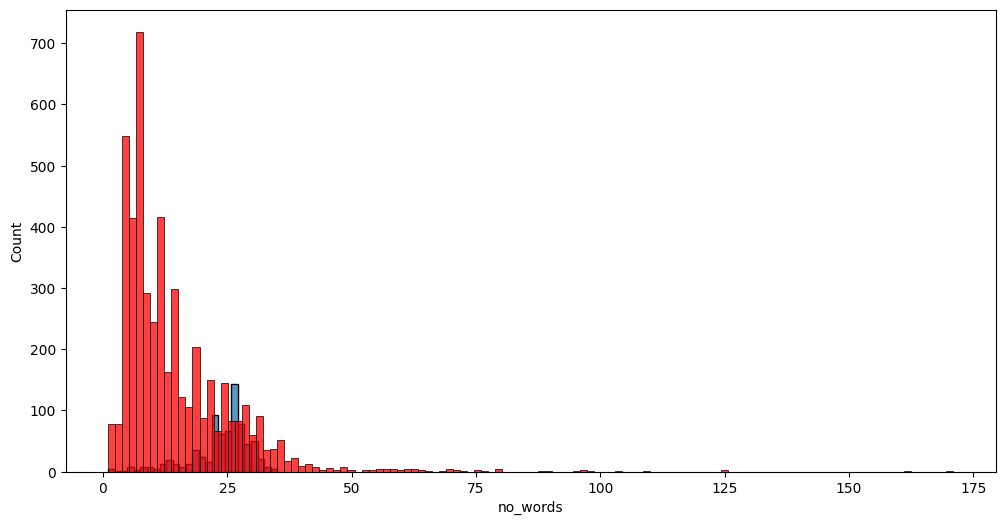

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(df[df['Category'] == 'spam']['no_words'])
sns.histplot(df[df['Category'] == 'ham']['no_words'], color='red')
plt.show()

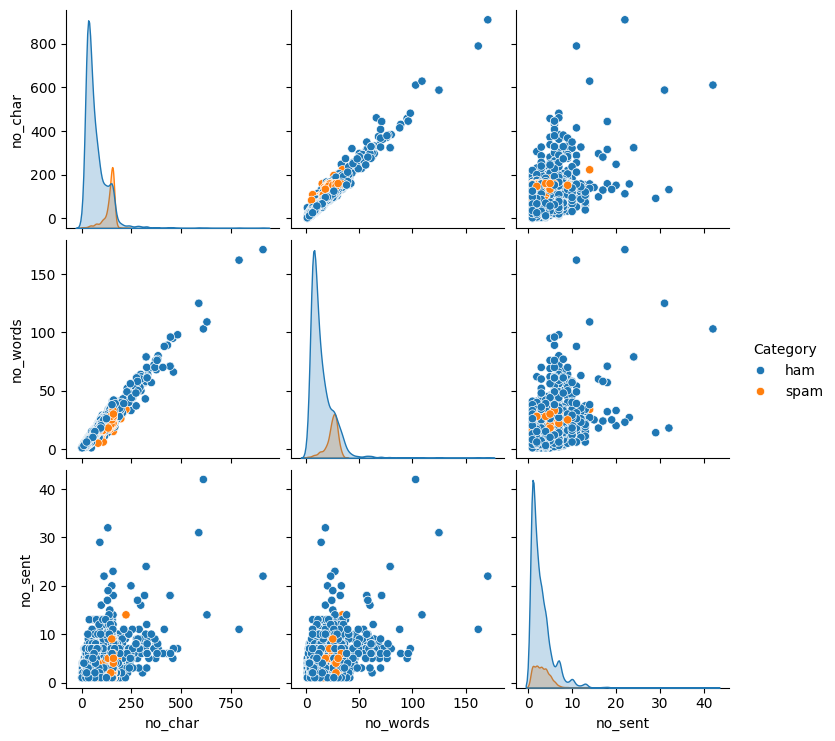

In [ ]:
sns.pairplot(df, hue='Category')
plt.show()

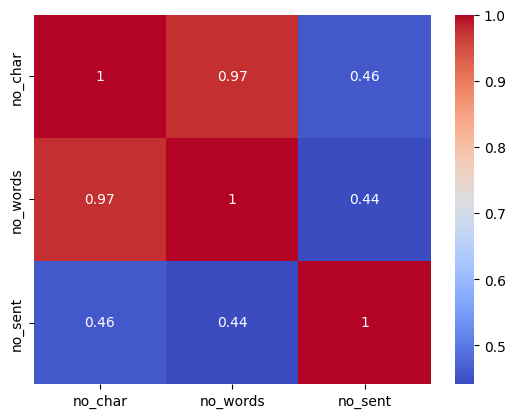

In [ ]:
sns.heatmap(df.select_dtypes(include=['int64', 'float64']).corr(), annot=True, cmap='coolwarm')
plt.show()

In [ ]:
def text_preprocessing(text):
  text = text.lower()

  text = nltk.word_tokenize(text)

  y = []
  stop_words = set(stopwords.words('english'))

  for i in text:
    if i.isalnum() and i not in stop_words:
      y.append(i)

  text = y[:]
  y.clear()

  for i in text:
    if i not in string.punctuation:
      y.append(i)

  text = y[:]
  y.clear()

  stemmer = SnowballStemmer('english')
  for i in text:
    y.append(stemmer.stem(i))

  return " ".join(y)

In [ ]:
df['clean_text'] = df['Message'].apply(text_preprocessing)
df.head()

,Category,Message,no_char,no_words,no_sent,clean_text
0,ham,"Go until jurong point, crazy.. Available only ...",111,20,9,go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,29,6,7,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28,2,free entri 2 wkli comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,49,11,7,u dun say earli hor u c alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,13,1,nah think goe usf live around though


In [ ]:
wc = WordCloud(width=500, height=500, min_font_size=10, background_color='black')

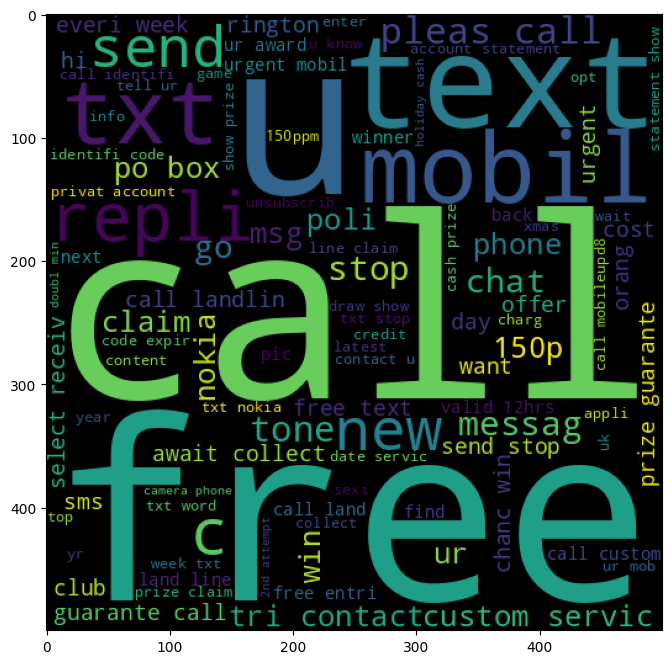

In [ ]:
spam_wc = wc.generate(df[df['Category'] == 'spam']['clean_text'].str.cat(sep=' '))

plt.figure(figsize=(20, 8))
plt.imshow(spam_wc)

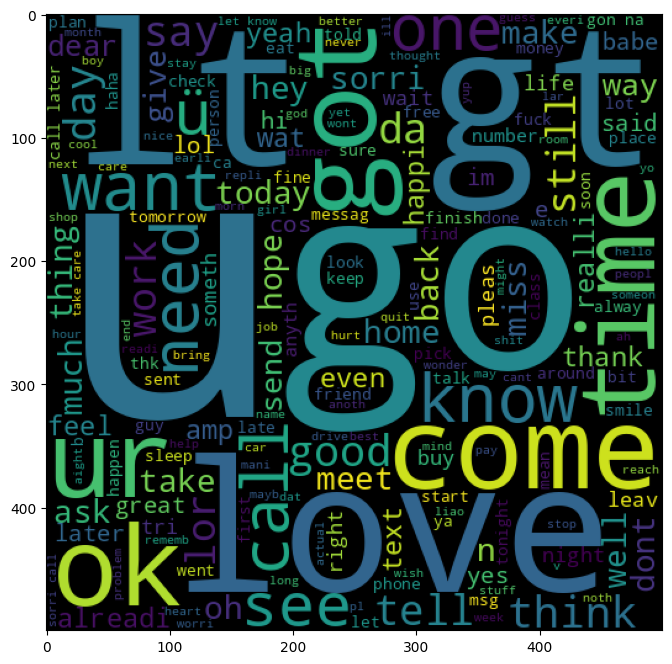

In [ ]:
ham_wc = wc.generate(df[df['Category'] == 'ham']['clean_text'].str.cat(sep=' '))

plt.figure(figsize=(20, 8))
plt.imshow(ham_wc)

In [ ]:
spam_corpus = []
for mail in df[df['Category'] == 'spam']['clean_text'].tolist():
  for word in mail.split():
    spam_corpus.append(word)

len(spam_corpus)

11506

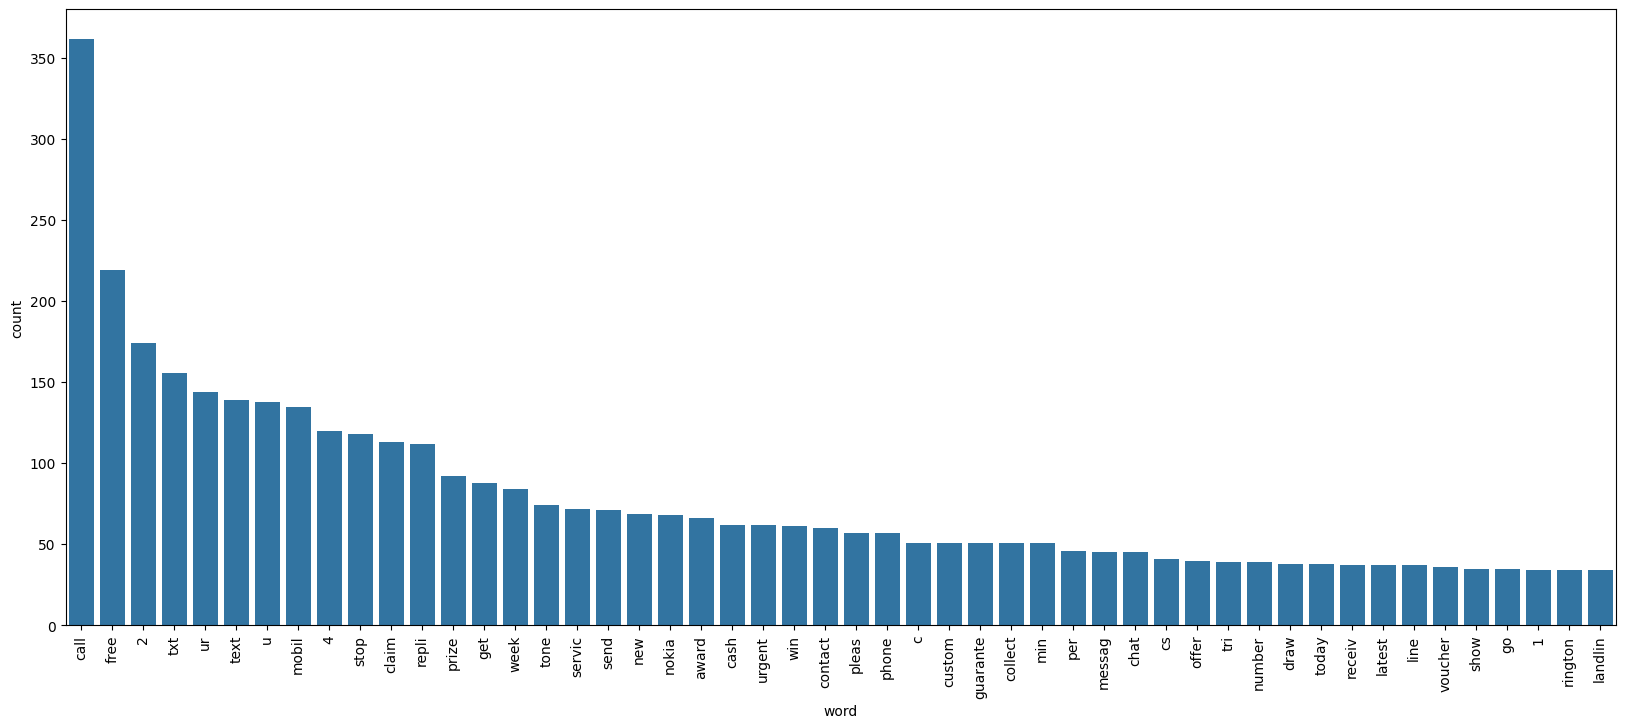

In [ ]:
spam_df = pd.DataFrame(Counter(spam_corpus).most_common(50),
                       columns=['word', 'count'])
plt.figure(figsize=(20, 8))
sns.barplot(x='word', y='count', data=spam_df)

plt.xticks(rotation='vertical')
plt.show()

In [ ]:
ham_corpus = []
for mail in df[df['Category'] == 'ham']['clean_text'].tolist():
  for word in mail.split():
    ham_corpus.append(word)

len(ham_corpus)

38819

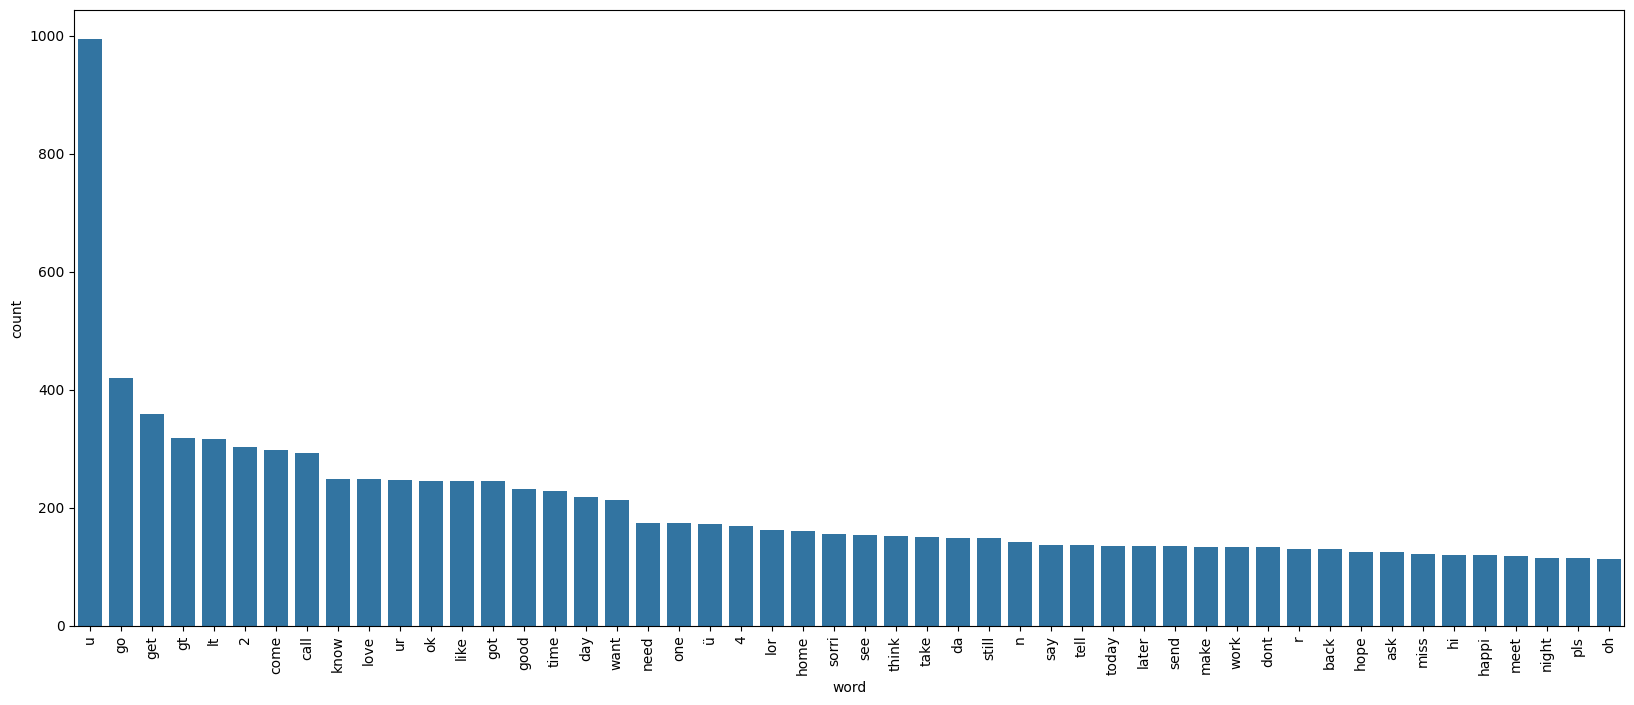

In [ ]:
ham_df = pd.DataFrame(Counter(ham_corpus).most_common(50),
                       columns=['word', 'count'])
plt.figure(figsize=(20, 8))
sns.barplot(x='word', y='count', data=ham_df)

plt.xticks(rotation='vertical')
plt.show()

In [ ]:
tfidf = TfidfVectorizer(max_features=17000)

x = tfidf.fit_transform(df['clean_text']).toarray()
y = df['Category']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [ ]:
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=0)
abc = AdaBoostClassifier(n_estimators=50, random_state=0)
bc = BaggingClassifier(n_estimators=50, random_state=0)
etc = ExtraTreesClassifier(n_estimators=50, random_state=0)
gbdt = GradientBoostingClassifier(n_estimators=50,random_state=0)
xgb = XGBClassifier(n_estimators=50,random_state=0)
sgd = SGDClassifier(class_weight='balanced', random_state=0)
lgbm = LGBMClassifier(random_state=0)

In [ ]:
classifiers = {
    'GaussianNB' : gnb,
    'MultinomialNB' : mnb,
    'BernoulliNB' : bnb,
    'SVC' : svc,
    'KNeighbors' : knc,
    'DecisionTree': dtc,
    'LogisticRegression': lrc,
    'RandomForest': rfc,
    'AdaBoost': abc,
    'BaggingClassifier': bc,
    'ExtraTreesClassifier': etc,
    'GradientBoosting': gbdt,
    'XGB': xgb,
    'SGD' : sgd,
    'LGBM' : lgbm
}

In [ ]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [ ]:
def train_classifier(classifiers, x_train, y_train, x_test, y_test):
  classifiers.fit(x_train, y_train)

  y_pred = classifiers.predict(x_test)
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)

  return classifier, accuracy, precision, y_pred

In [ ]:
algorithm_names = []
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

for name, classifier in classifiers.items():
  fitted_classifier, current_accuracy, current_precision, y_pred = train_classifier(classifier, x_train, y_train, x_test, y_test)

  classifiers[name] = fitted_classifier

  print("For ", name)
  print("Accuracy - ", current_accuracy)
  print("Precision - ", current_precision,'\n')

  algorithm_names.append(name)
  accuracy_scores.append(current_accuracy)
  precision_scores.append(current_precision)
  recall_scores.append(recall_score(y_test, y_pred))
  f1_scores.append(f1_score(y_test, y_pred))



For  GaussianNB
Accuracy -  0.8618834080717489
Precision -  0.5107142857142857 

For  MultinomialNB
Accuracy -  0.9668161434977578
Precision -  1.0 

For  BernoulliNB
Accuracy -  0.9713004484304932
Precision -  0.9705882352941176 

For  SVC
Accuracy -  0.9802690582959641
Precision -  0.9859154929577465 

For  KNeighbors
Accuracy -  0.905829596412556
Precision -  1.0 

For  DecisionTree
Accuracy -  0.9515695067264573
Precision -  0.8955223880597015 

For  LogisticRegression
Accuracy -  0.95695067264574
Precision -  0.9745762711864406 

For  RandomForest
Accuracy -  0.97847533632287
Precision -  1.0 

For  AdaBoost
Accuracy -  0.9237668161434978
Precision -  0.8571428571428571 

For  BaggingClassifier
Accuracy -  0.97847533632287
Precision -  0.925 

For  ExtraTreesClassifier
Accuracy -  0.9820627802690582
Precision -  0.9861111111111112 

For  GradientBoosting
Accuracy -  0.9623318385650225
Precision -  0.9916666666666667 

For  XGB
Accuracy -  0.9748878923766816
Precision -  0.97142857

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [ ]:
performance = pd.DataFrame({'Algorithm': algorithm_names, 'Accuracy': accuracy_scores, 'Precision': precision_scores, 'Recall': recall_scores, 'F1 Score': f1_scores}).sort_values('Precision', ascending=False)
performance

,Algorithm,Accuracy,Precision,Recall,F1 Score


In [ ]:
multinomial_mb = MultinomialNB()
multinomial_mb.fit(x_train, y_train)

multinomial_pred = multinomial_mb.predict(x_test)
print('Accuracy: ', accuracy_score(y_test, multinomial_pred))
print('Precision: ', precision_score(y_test, multinomial_pred))

NameError: name 'x_train' is not defined

In [ ]:
unseen_messages = [
    "You have won $1000! Click here to claim your prize.",
    "Limited-time offer! Buy one get one free on all items.",
    "Congratulations! Your account has been selected for a gift card.",
    "URGENT: Your loan is approved. Contact us immediately.",
    "Earn $5000 per week from home. Sign up now!",
    "Hey, are we meeting for lunch tomorrow?",
    "Don’t forget to submit your project by Friday.",
    "Can you send me the report by end of day?",
    "Happy birthday! Hope you have a great day.",
    "Let’s catch up over coffee this weekend.",
    "Congratulations! Your account has been selected for a gift card."
]


In [ ]:
X_unseen = tfidf.transform(unseen_messages)

In [ ]:
best_model = classifiers['SVC']

X_unseen = tfidf.transform(unseen_messages)
predictions = best_model.predict(X_unseen.toarray())

for msg, label in zip(unseen_messages, predictions):
    print(f"Message: {msg}\nPredicted: {'Spam' if label == 1 else 'Not Spam'}\n")


In [ ]:
df['Category'].value_counts()